<h1>Experimentation Notebook for Twitter Sentiment Analysis</h1>
This notebook covers all work done in building the backend portion of the Twitter Sentiment Trend app.
The NLTK sentiment analyzer will be compared with the BERT analyzer and benchmarked against the true results in the validation set.

<h3> Initializing packages and datasets </h3>

In [129]:
# Importing necessary packages + initializing settings
import pandas as pd
import datetime
import numpy as np
import nltk
import re
import tweepy
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from collections import Counter
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
from matplotlib.collections import LineCollection
from scipy.special import softmax
from string import punctuation
import matplotlib.pyplot as plt
from secret import * # Contains the OAuth authentication tokens.

MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

# Loading data
testing_data = pd.read_csv("./twitter_validation.csv", index_col=0, names=["Index","Entity","Sentiment","Tweet"])

# Converting indices in dataset to a list
indices = testing_data.index.values.tolist()

ROLLING = 10 # number of tweets sampled by API

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<h3> Defining <code> multi_color_chart</code> function</h3>

Function for plotting encoded multi color chart.

In [130]:
def multi_color_chart(y):
    """
    multi_color_chart takes as input sentiment data and returns a fig object
    which is a line plot color-coded to the polarity of the data.
    
    """
    fig, ax = plt.subplots()

    # Creating line segments to be color coded
    x_val = np.linspace(0, len(y), len(y))
    points = np.array([x_val, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Setting up bounds for color coding and choosing color theme
    norm = plt.Normalize(y.min(), y.max())
    lc = LineCollection(segments, cmap='seismic_r', norm=norm)
    # Using input array as color reference
    lc.set_array(y)
    lc.set_linewidth(2)
    line = ax.add_collection(lc)

    # This is done to avoid annoying scaling errors
    ax.plot(y*np.nan)

    tick_spacing = round(max(x_val)/5)

    ax.set_yticks([])
    # ax.set_xticks(x_val[0:-1:tick_spacing],labels=['24','18', '12', '6', 'Now'])
    # ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.set_ylabel("Tweet Sentiment")
    ax.set_xlabel("Time")

    return fig, ax

<h3> Defining <code>clean_tweet</code> function </h3>

The function processes a raw tweet and returns a list of words separated by space characters + the hashtags used in the tweet.
The code removes special characters, punctuation, numbers and stopwords (e.g., "a", "the", "for", etc.).

In [131]:
def clean_tweet(tweet):
    """
    This function processes the tweet into a string array for NLP sentiment analysis.    
    """

    # Removing RT from tweet (can't figure out how to filter out retweets with Twitter APIv2)
    remove_RT = lambda x: re.compile('RT @').sub('@',x,count=1).strip() 
    tweet = remove_RT(tweet)

    # Removing mentions with regex
    tweet = re.sub(r'@[A-Za-z0-9_]+', '', tweet)

    # Removing links
    tweet = re.sub(r"http\S+", "", tweet)
    tweet = re.sub(r"www.\S+", "", tweet) 

    # Extracting then removing hashtags
    hashtags = re.findall(r"#(\w+)", tweet)
    tweet = re.sub("#[A-Za-z0-9_]+","", tweet)

    # Converting uppercase characters
    tweet = tweet.lower()

    # Splitting up all words into array of strings
    tokens = tweet.split()

    # Removing punctuation
    table = str.maketrans(" "," ",punctuation)
    tokens = [w.translate(table) for w in tokens]

    # Removing alpha/numerical words
    token = [w for w in tokens if w.isalpha()]

    for idx in range(len(token)):
        t = [ch for ch in token[idx] if ch.isalpha()]
        token[idx]=''.join(t)

    # Removing stopwords e.g., "a", "the", "for", etc.
    stop_words = stopwords.words("english")
    new_tweet = [w for w in token if w not in stop_words]

    return ' '.join(new_tweet), ' '.join(hashtags)

<h3> Defining <code>sort_freq</code> function </h3>

The functions takes as input a list of words and returns two lists:
-word_labels which is the list containing all words in the input list
-word_counts which is the count of the word in the word_labels list
Both lists are sorted in descending order.

In [132]:
def sort_freq(input_text_list):
    """
    sort_freq takes as input a list of words and returns two lists, 
    word_counts which is the count of the word in the word_labels list.
    Both lists are sorted in descending order.
    """
    
    counts = Counter(" ".join(input_text_list).split(" "))

    # Sorting distribution from highest to lowest frequency
    labels, values = zip(*counts.items())
    word_labels = np.array(labels)[np.argsort(values)[::-1]]
    word_counts = np.array(values)[np.argsort(values)[::-1]]

    return word_labels, word_counts

<h3> Defining <code>analyze_tweet_nltk</code> function </h3>

This function returns statistics on processed set of tweets.
Returns frequency data as well as sentiment analysis using NLTK polarity score sentiment analyzer.

In [133]:
'''
This function returns statistics on processed set of tweets.
Returns frequency data as well as sentiment analysis.
'''

def analyze_tweet_nltk(input_tweets):

    all_sentiment = []

    count = 0

    for idx in range(len(input_tweets)):   
        temp = sentiment_analyzer.polarity_scores(input_tweets[idx])
        all_sentiment.append(temp["compound"])

    
    #freq_dist_tweet = nltk.FreqDist(input_tweets) 

    # Acquiring frequency distribution of words
    counts = Counter(str(input_tweets).split())

    labels, values = zip(*counts.items())

    word_labels = np.array(labels)[np.argsort(values)[::-1]]
    word_counts = np.array(values)[np.argsort(values)[::-1]]

    return all_sentiment, word_counts, word_labels

<h3> Defining <code>analyze_tweet_bert</code> function </h3>

This function returns statistics on processed set of tweets.
Returns frequency data as well as sentiment analysis using roBERTa polarity score sentiment analyzer.

In [193]:
'''
This function returns statistics on processed set of tweets.
Returns frequency data as well as sentiment analysis.
Uses roBERTa https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest
'''

def analyze_tweet_bert(input_tweets):

    all_sentiment = []
    for idx in range(len(input_tweets)): 
        encoded_input = tokenizer(input_tweets[idx], return_tensors='pt')
        output = model(**encoded_input)
        scores = output[0][0].detach().numpy()
        scores = softmax(scores)
        score = (-1*scores[0]+scores[1]/3+scores[2])
        # score = -1*scores[0]+scores[2]

        # if scores[1] == max(scores):
        #     score = scores[1]/2
        # elif scores[0] == max(scores):
        #     score = -1*scores[0]
        # elif scores[2] == max(scores):
        #     score = scores[2]

        all_sentiment.append(score)

    word_labels, word_counts = sort_freq(input_tweets)

    return all_sentiment, word_counts, word_labels

<h3> Data collection function <code> collect_data </code> </h3>

Collects tweet data (date and text) when keyword is entered.

In [135]:
def collect_data(keyword, hours_num, hour_interval=2):
    """
    collect_data uses the Twitter API via tweepy module to collect tweets based
    on a search query. WIth current Essential Access, only Twitter API v2 can
    be used. Searches are limited to a maximum of 7 days before current day and
    only 100 tweets can be accessed per search. This function collects X tweets
    per hour and returns a dictionary with the raw text and timestamp.
    """

    raw_tweets = []
    tweet_time = []
    
    # Query
    keyword = keyword + " lang:en"

    for date_idx in range(hours_num,0,-1):

        date_start = datetime.datetime.now() - datetime.timedelta(hours = date_idx*hour_interval)
        date_until = date_start + datetime.timedelta(hours=hour_interval)

        tweets = api.search_recent_tweets(query=keyword,
                                    max_results=ROLLING,
                                    end_time=date_until,
                                    start_time=date_start,
                                    tweet_fields=["text","created_at"])


        if tweets.data:
            for twt in tweets.data:
                raw_tweets.append(twt.text)
                tweet_time.append(twt.created_at)
    
    if not raw_tweets:
        return {"time": [date_start], "text": [""]} 

    return {"time": tweet_time, "text": raw_tweets}

<h3> Rolling average function <code> moving_average </code> implemented with <code> convolve </code> </h3>

In [136]:
def moving_average(x):
    """
    moving_average calculates the moving average of an array of numbers using
    convolution. The input array is convolved with a smaller array of ones,
    equivalent to a cumulative sum, then divided by the length of the array of
    ones. 
    """
    return np.convolve(x, np.ones(ROLLING), 'same') / ROLLING

<h4> Example of <code> clean_tweet </code> function

In [137]:
# Testing tweet cleaner
token_tweets = []
hashtags = []

for idx in indices:
    tweett,hasht = clean_tweet(testing_data.Tweet.loc[idx])
    token_tweets.append(tweett)
    hashtags.append(hasht)


In [138]:
# Original tweet
idx = 22
print(testing_data.Tweet.loc[indices[idx]])

Call of duty warzone (livestream) w/ subs #Warzone youtu.be/7BhH_pjOMU4 via @YouTube Please come watch this AMAZING Call of Duty Warzone stream from this AMAZING streamer! It'd be really, really nice to give him some views and likes as well! 😀 #COD #CallofDuty #Warzone


In [139]:
# Clean output
print(token_tweets[idx])
print("Hashtags=",hashtags[idx])

call duty warzone livestream w subs via please come watch amazing call duty warzone stream amazing streamer itd really really nice give views likes well
Hashtags= Warzone COD CallofDuty Warzone


<h4> Testing <code> FreqDist </code> method of <code> nltk </code> </h4>
Wanted to use this method for word count analysis but doesn't seem to work well...

In [140]:
freq_dist_tweet = nltk.FreqDist(token_tweets)
freq_dist_tweet.most_common(3)

[('played interesting quiz amazon try luck chance win exciting rewards', 5),
 ('red dead redemption', 4),
 ('wow', 3)]

<h4> Testing in-house solution for word count analysis </h4>
Uses <code>Counter()</code> method from <code>collections</code> module

In [141]:
counts_test = Counter(str(token_tweets).split())

import itertools
dict(itertools.islice(counts_test.items(),10))

{"['mentioned": 1,
 'facebook': 21,
 'struggling': 2,
 'motivation': 1,
 'go': 28,
 'run': 7,
 'day': 22,
 'translated': 1,
 'great': 21,
 'auntie': 1}

<h4> Testing <code> nltk</code> sentiment analyzer output </h4>
<code> polarity_scores </code> returns 4 values. The first 3 are on a scale of 0 to 1 and indicate presence of negativity (<code> neg </code>), neutrality (<code> neu </code>) or positivity (<code> pos </code>). The fourth value <code> compound </code> is on a scale of -1 to +1 and is calculated separately. 

In [264]:
# Testing nltk sentiment analyzer
idx = 280
sentiment_analyzer = SentimentIntensityAnalyzer()
print(testing_data.Tweet.loc[indices[idx]])
print(sentiment_analyzer.polarity_scores(token_tweets[idx]))
print("True sentiment:",testing_data.Sentiment.loc[indices[idx]])

# Weird cases: idx = 150, 10, 650, 670, 200, 210
# Good cases: idx = 30, 800, 780, 790
# Bert outperforming nltk: idx = 450, 400
# nltk outperforming bert: idx = 600,

Pissing people off in FIFA and on twitter 😭😭😭
{'neg': 0.474, 'neu': 0.526, 'pos': 0.0, 'compound': -0.4019}
True sentiment: Negative


<h4> Testing <code> bert</code> sentiment analyzer output </h4>
<code> scores </code> contains 3 values. They are on a scale of 0 to 1 and indicate presence of negativity (<code> neg </code>), neutrality (<code> neu </code>) or positivity (<code> pos </code>). The three values are combined into a <code> compound</code> score calculated as <code> -1*neg + neu/2 + pos</code>, giving a score between -1 and 1.

In [265]:
# encoded_input = tokenizer(testing_data.Tweet.loc[indices[idx]], return_tensors='pt')
encoded_input = tokenizer(token_tweets[idx], return_tensors='pt')
output = model(**encoded_input)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
score = (-1*scores[0]+scores[1]/2+scores[2])

print(testing_data.Tweet.loc[indices[idx]])
ranking = np.argsort(scores)
ranking = ranking[::-1]
for i in range(scores.shape[0]):
    l = config.id2label[ranking[i]]
    s = scores[ranking[i]]
    print(f"{i+1}) {l} {np.round(float(s), 4)}")

if scores[1] == max(scores):
    score = scores[1]/2
elif scores[0] == max(scores):
    score = -1*scores[0]
elif scores[2] == max(scores):
    score = scores[2]

score = round(-1*scores[0]+scores[1]/3+scores[2],2)

print("Compound score:",round(score,2))
print("True sentiment:",testing_data.Sentiment.loc[indices[idx]])

Pissing people off in FIFA and on twitter 😭😭😭
1) Negative 0.6828
2) Neutral 0.2473
3) Positive 0.0699
Compound score: -0.53
True sentiment: Negative


<h4> Benchmarking <code> nltk</code> and <code> bert</code> sentiment analyzers with true results </h4>
The accuracy of the sentiment analyzer is benchmarked using the true results. For the purposes of testing, 'irrelevant' and 'neutral' were grouped together. The 'neutral' category was thresholded as being between a compound value of -0.2 to 0.2. Smaller numbers were deemed to be negative and larger numbers were deemed to be positive.

The rates calculated indicate higher accuracy as the fraction approaches 1. Values greater than 1 represent overshooting by the model, and values less than 1 represent undershooting. Accuracy can be changed as the threshold is tweaked, representing some ambiguity in the definition of "neutral" in the analyzer.

In [229]:
pos_count_true = 0
neg_count_true = 0
neu_count_true = 0

pos_count_nltk = 0
neg_count_nltk = 0
neu_count_nltk = 0

pos_count_bert = 0
neg_count_bert = 0
neu_count_bert = 0

nltk_sentiment, word_counts, word_labels = analyze_tweet_nltk(token_tweets)
bert_sentiment, word_counts, word_labels = analyze_tweet_bert(testing_data.Tweet)

for idx in range(len(nltk_sentiment)):

    if testing_data.Sentiment.loc[indices[idx]]=='Positive':
        pos_count_true+=1
    elif testing_data.Sentiment.loc[indices[idx]]=='Negative':
        neg_count_true+=1
    else:
        neu_count_true+=1


    if nltk_sentiment[idx] > 0.45:
        pos_count_nltk+=1
    elif nltk_sentiment[idx] < -0.45:
        neg_count_nltk+=1
    else:
        neu_count_nltk+=1

    if bert_sentiment[idx] > 0.45:
        pos_count_bert+=1
    elif bert_sentiment[idx] < -0.45:
        neg_count_bert+=1
    else:
        neu_count_bert+=1


nltk_accuracy = [pos_count_nltk/pos_count_true,
                    neg_count_nltk/neg_count_true,
                    neu_count_nltk/neu_count_true]

# Closer to 1 is better
print("NLTK true positive rate:",round(nltk_accuracy[0],2),
"\nNLTK true negative rate:",round(nltk_accuracy[1],2),
"\nNLTK true neutral rate:",round(nltk_accuracy[2],2))

bert_accuracy = [pos_count_bert/pos_count_true,
                    neg_count_bert/neg_count_true,
                    neu_count_bert/neu_count_true]

# Closer to 1 is better
print("BERT true positive rate:",round(bert_accuracy[0],2),
"\nBERT true negative rate:",round(bert_accuracy[1],2),
"\nBERT true neutral rate:",round(bert_accuracy[2],2))

rolling_sentiment_nltk = moving_average(nltk_sentiment)
rolling_sentiment_bert = moving_average(bert_sentiment)


KeyError: 0

In [101]:
print(neg_count_true)
print(neg_count_bert)

266
24


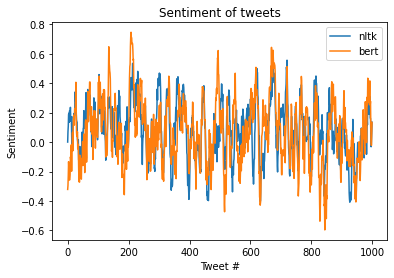

In [197]:
plt.figure
plt.plot(rolling_sentiment_nltk, label='nltk')
plt.plot(rolling_sentiment_bert, label='bert')
plt.xlabel("Tweet #")
plt.ylabel("Sentiment")
plt.title("Sentiment of tweets")
plt.legend()

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

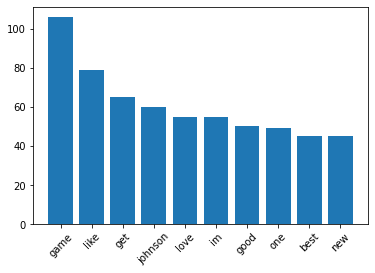

In [153]:
plt.figure
plt.bar(word_labels[0:10],word_counts[0:10])
plt.xticks(rotation=45)

<h3> Testing Twitter API... </h3>

In [170]:
keyword = "cibc"

keyword = keyword + " lang:en"

api = tweepy.Client(BEARER_TOKEN,CONSUMER_KEY, CONSUMER_SECRET, ACCESS_TOKEN, ACCESS_TOKEN_SECRET)

num_hours = 24
raw_tweet_data = collect_data(keyword, num_hours, hour_interval=1)

<h3> Printing out example tweet + time created </h3>

In [186]:
idxt=19

print(str(raw_tweet_data["time"][idxt]))
print(raw_tweet_data["text"][idxt])

2022-05-21 22:38:01+00:00
Application Support at CIBC
Were building a relationshiporiented bank for the modern world We need talented passionate professionals who are dedicated to doing whats right for ou...
#Support #remoteworking 
https://t.co/hOlc1WFqrZ


In [187]:
processed_tweets = []
hashtags = []
for idx in range(len(raw_tweet_data["text"])):
    temptweet, temphash = clean_tweet(str(raw_tweet_data["text"][idx]))
    processed_tweets.append(temptweet)
    hashtags.append(temphash)

print(str(raw_tweet_data["text"][idxt]))  
print("\nClean tweet") 
print(processed_tweets[idxt])
print("Hashtags =",hashtags[idxt])


Application Support at CIBC
Were building a relationshiporiented bank for the modern world We need talented passionate professionals who are dedicated to doing whats right for ou...
#Support #remoteworking 
https://t.co/hOlc1WFqrZ

Clean tweet
application support cibc building relationshiporiented bank modern world need talented passionate professionals dedicated whats right ou
Hashtags = Support remoteworking


In [194]:
nltk_sentiment, word_counts, word_labels = analyze_tweet_nltk(processed_tweets)
bert_sentiment, word_counts, word_labels = analyze_tweet_bert(processed_tweets)

rolling_sentiment_nltk = moving_average(nltk_sentiment)
rolling_sentiment_bert = moving_average(bert_sentiment)

nltk_df = pd.DataFrame({"Sentiment":rolling_sentiment_nltk, "Time":raw_tweet_data["time"]})
bert_df = pd.DataFrame({"Sentiment":rolling_sentiment_bert, "Time":raw_tweet_data["time"]})

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='Time', ylabel='Tweet Sentiment'>)

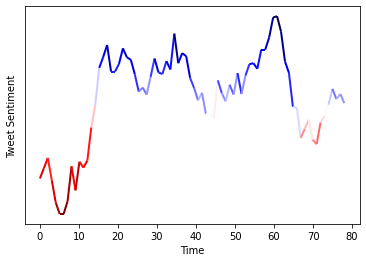

In [181]:
multi_color_chart(nltk_df["Sentiment"])

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='Time', ylabel='Tweet Sentiment'>)

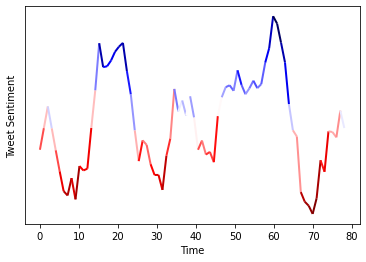

In [180]:
multi_color_chart(bert_df["Sentiment"])

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

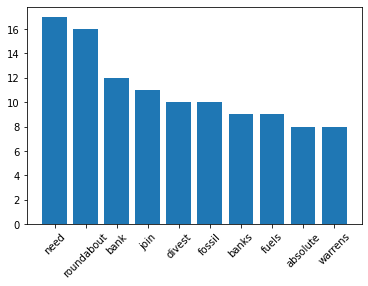

In [168]:
plt.figure()
plt.bar(word_labels[1:11],word_counts[1:11])
plt.xticks(rotation=45)